# Teste do Algoritmo Sampling
Teste dos algoritmos de detecção de anomalias para comparação e seleção dos integrantes do aplicativo

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score
from sklearn.model_selection import GridSearchCV
from pyod.utils.data import evaluate_print
import matplotlib.pyplot as plt

tabelafinal = pd.DataFrame(columns=['algoritmo','contaminacao','acuracia','precisao','recall','f1','fn','fp','tp'])
print(tabelafinal)
 
def avalia(clf_name,Y,y_train_scores,y_train_pred):
    # Avalia e imprime os resultados
    print("Avaliação do modelo "+clf_name+":")
    evaluate_print(clf_name, Y, y_train_scores)
    tn, fp, fn, tp = confusion_matrix(Y,y_train_pred).ravel()
    print('Acurácia='+str(accuracy_score(Y,y_train_pred)*100))   
    print('Precisão='+str(precision_score(Y,y_train_pred)*100))
    print('Recall='+str(recall_score(Y,y_train_pred)*100))
    print('Falso Positivo='+str(fp))
    print('Falso Negativo='+str(fn))
    print('F1-score='+str(f1_score(Y,y_train_pred)*100))
    print('ROC='+str(roc_auc_score(Y,y_train_scores)))

def gera_matriz_de_confusao(Y,y_train_pred,clf_name):
    cm = confusion_matrix(Y,y_train_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal','Anomalia'])
    disp.plot(cmap=plt.cm.Blues)
    disp.ax_.set(title='Matriz de Confusão do '+clf_name,xlabel='Valores preditos', ylabel='Valores reais')
    plt.show()
    
def grava_avaliacao(clf_name,Y,y_train_scores,y_train_pred,contamination):
    # Grava os resultados da avaliação na tabela final
    tn, fp, fn, tp = confusion_matrix(Y,y_train_pred).ravel()
    ac=("{:.2f}".format(round(accuracy_score(Y,y_train_pred)*100,2))).replace(".", ",")
    print('Acurácia='+ac)   
    pc=("{:.2f}".format(round(precision_score(Y,y_train_pred)*100,2))).replace(".", ",")
    print('Precisão='+pc)
    rc=("{:.2f}".format(round(recall_score(Y,y_train_pred)*100,2))).replace(".", ",")
    print('Recall='+rc)
    f1=("{:.2f}".format(round(f1_score(Y,y_train_pred)*100,2))).replace(".", ",")
    print('F1='+f1)
    print('Falso Negativo='+str(fn))
    print('Falso Positivo='+str(fp))
    print('Verdadeiro Positivo='+str(tp))
    cont=str(round(contamination,2)).replace(".",",")
    tabelafinal.loc[len(tabelafinal.index)] = [clf_name,cont,ac,pc,rc,f1,fn,fp,tp] 
      

Empty DataFrame
Columns: [algoritmo, contaminacao, acuracia, precisao, recall, f1, fn, fp, tp]
Index: []


# Recuperação dos dados a serem utilizados na avaliação
Leitura do arquivo gerado para o material de catmat_id= 445485 -> Descrição:'ÁGUA MINERAL NATURAL, TIPO SEM GÁS MATERIAL EMBALAGEM PLÁSTICO TIPO EMBALAGEM RETORNÁVEL'.

In [2]:
import os
import pandas as pd
def load_itens(path):
    csv_path = os.path.join(path,"445485.csv")
    return pd.read_csv(csv_path)

df=load_itens(".")
## Retira os campos que não serão utilizados no treinamento
df = df.drop(['licitacao_contrato'],axis=1)
df = df.drop(['id'],axis=1)
df = df.drop(['data'],axis=1)
df = df.drop(['catmat_id'],axis=1)
df = df.drop(['unidade'],axis=1)
df = df.drop(['valor_total'],axis=1)
df = df.drop(['municipio_uasg'],axis=1)
df = df.drop(['municipio_fornecedor'],axis=1)
print(df)

     quantidade  valor_unitario  distancia_uasg_fornecedor  anomalia
0           420           12.00                    935.371         0
1         28000            5.88                      0.000         0
2          2100            5.09                      0.000         0
3           360            7.70                    172.788         0
4           120            7.70                    172.788         0
..          ...             ...                        ...       ...
725        5000           10.45                    398.772         0
726        4000           13.45                    398.772         0
727        1440           11.37                      0.000         0
728        1440           10.58                      0.000         0
729          10           20.00                      0.000         0

[730 rows x 4 columns]


# Separação do Label dos dados

In [3]:
X = df.iloc[:, :-1]
Y = df.iloc[:, -1]
print(X)
print(Y)

     quantidade  valor_unitario  distancia_uasg_fornecedor
0           420           12.00                    935.371
1         28000            5.88                      0.000
2          2100            5.09                      0.000
3           360            7.70                    172.788
4           120            7.70                    172.788
..          ...             ...                        ...
725        5000           10.45                    398.772
726        4000           13.45                    398.772
727        1440           11.37                      0.000
728        1440           10.58                      0.000
729          10           20.00                      0.000

[730 rows x 3 columns]
0      0
1      0
2      0
3      0
4      0
      ..
725    0
726    0
727    0
728    0
729    0
Name: anomalia, Length: 730, dtype: int64


# Pré-processamento normalização dos dados min-max e robust

In [4]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import numpy as np

# Cria uma instância do RobustScaler
robust_scaler = RobustScaler()

# Ajusta e transforma os dados com o RobustScaler
X_robust = robust_scaler.fit_transform(X)

# Cria uma instância do MinMaxScaler
minmax_scaler = MinMaxScaler()

# Ajusta e transforma os dados com o MinMaxScaler
X_minmax =  minmax_scaler.fit_transform(X)
X_minmaxrobust =  minmax_scaler.fit_transform(X_robust)



# Sampling

In [5]:
# class pyod.models.sampling.Sampling(contamination=0.1, subset_size=20, metric='minkowski', metric_params=None, 
# random_state=None)

from pyod.models.sampling import Sampling
clf_name = 'Sampling'
clf = Sampling()

parametros = {'contamination': [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15],
              'subset_size':[10,20,30,40,50,60,70,80,90,100]
}

grid = GridSearchCV(estimator = clf,          
                param_grid = parametros,  
                scoring = 'recall',           
                cv = 10)  

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarnin

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarnin

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and be

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

Best Score:  0.8
Best Params:  {'contamination': 0.12, 'subset_size': 90}
Avaliação do modelo Sampling:
Sampling ROC:0.8381, precision @ rank n:0.3333
Acurácia=88.9041095890411
Precisão=15.909090909090908
Recall=66.66666666666666
Falso Positivo=74
Falso Negativo=7
F1-score=25.688073394495415
ROC=0.8381355363019678


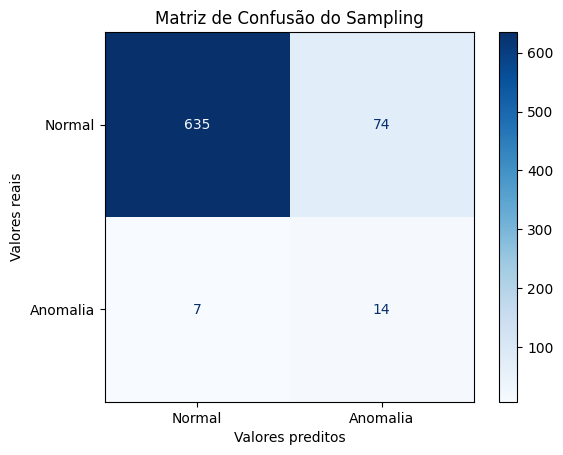

Acurácia=88,90
Precisão=15,91
Recall=66,67
F1=25,69
Falso Negativo=7
Falso Positivo=74
Verdadeiro Positivo=14


In [6]:
# Teste com as duas normalizações

grid_result = grid.fit(X_minmaxrobust, Y)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

contamination=grid_result.best_params_['contamination']

funcao=clf_name+'(**grid.best_params_)'
clf = eval(funcao)
clf.fit(X_minmaxrobust)

avalia(clf_name,Y,clf.decision_scores_,clf.labels_)
gera_matriz_de_confusao(Y,clf.labels_ ,clf_name)
grava_avaliacao(clf_name+' Robusta e minmax',Y,clf.decision_scores_,clf.labels_,round(contamination,2))

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarnin

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarnin

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has

Best Score:  0.8
Best Params:  {'contamination': 0.13, 'subset_size': 40}
Avaliação do modelo Sampling:
Sampling ROC:0.9313, precision @ rank n:0.2941
Acurácia=88.21917808219179
Precisão=15.789473684210526
Recall=71.42857142857143
Falso Positivo=80
Falso Negativo=6
F1-score=25.862068965517242
ROC=0.93129155752569


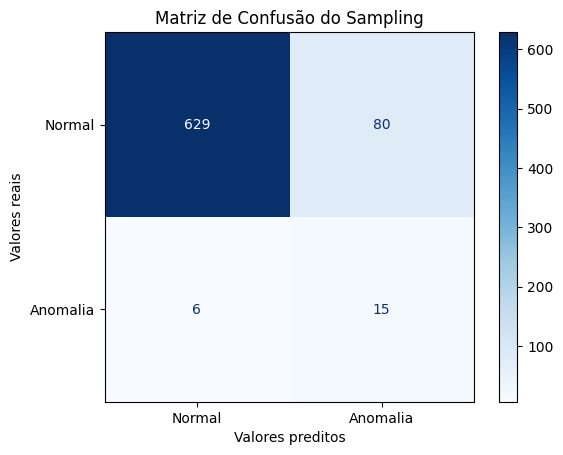

Acurácia=88,22
Precisão=15,79
Recall=71,43
F1=25,86
Falso Negativo=6
Falso Positivo=80
Verdadeiro Positivo=15


In [7]:
# Teste com só MinMax

grid_result = grid.fit(X_minmax, Y)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

contamination=grid_result.best_params_['contamination']

funcao=clf_name+'(**grid.best_params_)'
clf = eval(funcao)
clf.fit(X_minmax)

avalia(clf_name,Y,clf.decision_scores_,clf.labels_)
gera_matriz_de_confusao(Y,clf.labels_ ,clf_name)
grava_avaliacao(clf_name+' minmax',Y,clf.decision_scores_,clf.labels_,round(contamination,2))

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarnin

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarnin

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarnin

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarnin

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and be

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  w

Best Score:  0.8
Best Params:  {'contamination': 0.05, 'subset_size': 10}
Avaliação do modelo Sampling:
Sampling ROC:0.9977, precision @ rank n:0.9048
Acurácia=97.3972602739726
Precisão=52.77777777777778
Recall=90.47619047619048
Falso Positivo=17
Falso Negativo=2
F1-score=66.66666666666666
ROC=0.997716434951978


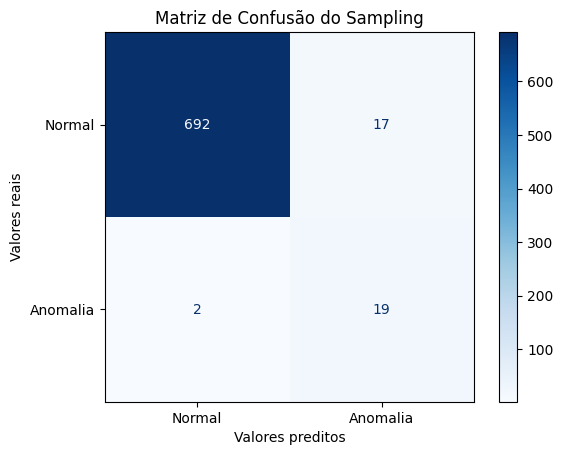

Acurácia=97,40
Precisão=52,78
Recall=90,48
F1=66,67
Falso Negativo=2
Falso Positivo=17
Verdadeiro Positivo=19


In [8]:
# Teste com só Robusta

grid_result = grid.fit(X_robust, Y)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

contamination=grid_result.best_params_['contamination']

funcao=clf_name+'(**grid.best_params_)'
clf = eval(funcao)
clf.fit(X_robust)

avalia(clf_name,Y,clf.decision_scores_,clf.labels_)
gera_matriz_de_confusao(Y,clf.labels_ ,clf_name)
grava_avaliacao(clf_name+' Robusta',Y,clf.decision_scores_,clf.labels_,round(contamination,2))

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarnin

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarnin

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and be

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarnin

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  w

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarnin

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarnin

C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\sklearn\neighbors\_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  warnings.warn(
C:\Users\rterr\.conda\envs\Mestrado310\lib\site-packages\pyod\models\base.py:430: UserWarning: y should not be presented in unsupervised learning.
  w

Best Score:  0.8
Best Params:  {'contamination': 0.05, 'subset_size': 10}
Avaliação do modelo Sampling:
Sampling ROC:0.9972, precision @ rank n:0.8095
Acurácia=97.80821917808218
Precisão=56.75675675675676
Recall=100.0
Falso Positivo=16
Falso Negativo=0
F1-score=72.41379310344827
ROC=0.9972462892067969


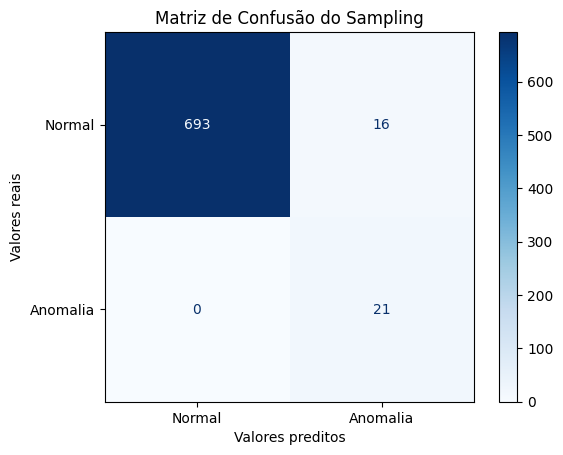

Acurácia=97,81
Precisão=56,76
Recall=100,00
F1=72,41
Falso Negativo=0
Falso Positivo=16
Verdadeiro Positivo=21


In [9]:
# Teste sem Normalização

grid_result = grid.fit(X, Y)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

contamination=grid_result.best_params_['contamination']

funcao=clf_name+'(**grid.best_params_)'
clf = eval(funcao)
clf.fit(X)

avalia(clf_name,Y,clf.decision_scores_,clf.labels_)
gera_matriz_de_confusao(Y,clf.labels_ ,clf_name)
grava_avaliacao(clf_name,Y,clf.decision_scores_,clf.labels_,round(contamination,2))

# Imprime a tabela final de avaliação

In [10]:
tabelafinal.sort_values("fn", axis = 0, ascending = True,
                 inplace = True, na_position ='last')
print(tabelafinal)

                   algoritmo contaminacao acuracia precisao  recall     f1  \
3                   Sampling         0,05    97,81    56,76  100,00  72,41   
2           Sampling Robusta         0,05    97,40    52,78   90,48  66,67   
1            Sampling minmax         0,13    88,22    15,79   71,43  25,86   
0  Sampling Robusta e minmax         0,12    88,90    15,91   66,67  25,69   

   fn  fp  tp  
3   0  16  21  
2   2  17  19  
1   6  80  15  
0   7  74  14  
